In [1]:
import numpy as np
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from scipy.optimize import fsolve, root, bisect
import os 
if not os.path.exists('figures'):
    os.makedirs('figures')

%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
!nvidia-smi

Tue Apr 30 22:05:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:4B:00.0 Off |                    0 |
| N/A   25C    P0              50W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [89]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def tf_2(etas, ws, lamb):
  return jnp.sum((ws**2) * etas**2/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-10, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if abs(f(x_next)) < abs_tol:
            return x_next
        x = x_next
    return x

def solve_kappa2(P, Ns:list, lamb, etaX, upper_bound=None, anneal_steps=1, **kwargs):
  if not upper_bound:
    upper_bound = lamb + 1e3
  D = Ns[0]
  if lamb == 0:
    if D == min(P, *Ns):
      return 0
    elif P == min(P, *Ns):
      fn = lambda kappa: 1 - D/P * df_1(etaX, kappa)
    else:
      N = min(Ns)
      fn = lambda kappa: N/D - df_1(etaX, kappa)
    return newton(fn, x0=0.0, **kwargs)
  
  def fn_lamb(kappa, lamb):
    ans = kappa * (1 - D/P * df_1(etaX, kappa))
    for N in Ns[1:]:
      ans *= N/D - df_1(etaX, kappa)
    return ans - lamb
  anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
  kappa = upper_bound
  for anneal_lamb in anneal_schedule:
    fn = lambda kappa: fn_lamb(kappa, anneal_lamb)
    kappa_next = newton(fn, x0=kappa, **kwargs)
    if not kappa_next: 
      print("Annealing didn't find kappa. Returning last value.")
      return kappa
    kappa = kappa_next
  return kappa

def estimate_df1_kappa1(lamb, X_tr, FX_tr):
  P, D = X_tr.shape
  N = FX_tr.shape[1]
  q = D/P
  if q >= 1:
    gram = FX_tr @ FX_tr.T / P
    df1 = jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)) @ gram)/D
    kappa1 = (jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)))/P)**(-1)
    return df1, kappa1
    
  else:
    cov = FX_tr.T @ FX_tr / P
    df1 = jnp.trace(jnp.linalg.inv(cov + lamb*np.identity(N)) @ cov)/D
    kappa1 = lamb/(1-q * df1)
    return df1, kappa1


In [90]:
def simulate_theory(Ns, qs, lambs, sigma_epsilon, X_spec, F_specs, teacher, X_te, y_te, num_X_seeds, num_F_seeds):
    if type(lambs) not in [list, np.ndarray]:
        lambs = [lambs]*len(qs)
    lambs = np.array(lambs)
    data = {}
    L = len(Ns)
    D = Ns[0]
    N = Ns[-1]
    Ss = [jnp.diag(X_spec)]
    if not F_specs:
        F_specs = [jnp.ones(N) for N in Ns[1:]]
    for F_spec in F_specs:
        Ss.append(jnp.diag(F_spec))        
    w = teacher
    for i in tqdm(range(len(qs))):
        q, lamb  = qs[i], lambs[i]
        P = int(D/q)
        y_hats = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        y_hats_clean = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        df1_empirical = np.zeros((num_X_seeds, num_F_seeds))
        kappa_GCV = np.zeros((num_X_seeds, num_F_seeds))
        Etrs = np.zeros((num_X_seeds, num_F_seeds))
        for X_seed in range(num_X_seeds):
            X_key = random.PRNGKey(X_seed)
            X_tr_key, e_key= random.split(X_key)
            epsilon = random.normal(e_key, (P, )) * sigma_epsilon
            X_tr = random.normal(X_tr_key, (P, D)) @ jnp.sqrt(Ss[0])
            y_tr = X_tr @ w + epsilon
            y_tr_clean = X_tr @ w

            for F_seed in range(num_F_seeds):
                F_key = random.PRNGKey(F_seed)
                F_keys = random.split(F_key, L)
                F = jnp.identity(D)
                for l in range(1, L):
                    F_l = random.normal(F_keys[l], (Ns[l-1], Ns[l])) @ jnp.sqrt(Ss[l])/np.sqrt(Ns[l-1])
                    F = F @ F_l
                FX_tr = X_tr @ F
                FX_te = X_te @ F
                
                if P > N:
                    cov = FX_tr.T @ FX_tr / P
                    w_star = jnp.linalg.solve(cov + lamb*np.identity(N), FX_tr.T @ y_tr / P)
                    w_star_clean = jnp.linalg.solve(cov + lamb*np.identity(N), FX_tr.T @ y_tr_clean / P)
                    y_hat_tr = FX_tr @ w_star
                    Etrs[X_seed, F_seed] = jnp.mean((y_tr - y_hat_tr)**2)
                else: 
                    gram = FX_tr @ FX_tr.T / P
                    w_star = FX_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr) / P
                    w_star_clean = FX_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr_clean) / P
                    Etrs[X_seed, F_seed] = lamb**2/P * jnp.sum((jnp.linalg.solve(gram + lamb*np.identity(P),  y_tr))**2)

                y_hats[X_seed, F_seed, :] = FX_te @ w_star
                y_hats_clean[X_seed, F_seed, :] = FX_te @ w_star_clean
                    
                df1_emp, kappa1 = estimate_df1_kappa1(lamb, X_tr, FX_tr)
                df1_empirical[X_seed, F_seed] = df1_emp
                kappa_GCV[X_seed, F_seed] = kappa1

        Eg = np.mean((y_hats - y_te[None, None, :])**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_te[None, None, :])**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        Bias =  np.mean((y_te - np.mean(y_hats_clean, axis=(0, 1)))**2)
        VarX = np.mean((jnp.mean(y_hats_clean, axis=1) - y_te[None, :])**2, axis=-1) - Bias
        VarF = np.mean((jnp.mean(y_hats_clean, axis=0) - y_te[None, :])**2, axis=-1) - Bias
        VarXF =  Signal - VarX - VarF - Bias
        VarXe = jnp.mean((jnp.mean(y_hats - y_hats_clean, axis=1))**2, axis=-1)
        VarXFe = Noise - VarXe
        data[q] = {
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': np.mean(Noise),
            'Noise_std': np.std(Noise),
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarF': np.mean(VarF),
            'VarF_std': np.std(VarF),
            'VarXF': np.mean(VarXF),
            'VarXF_std': np.std(VarXF),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'VarXFe': np.mean(VarXFe),
            'VarXFe_std': np.std(VarXFe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1': np.mean(df1_empirical),
            'df1_std': np.std(df1_empirical),
            'kappa_GCV': np.mean(kappa_GCV),
            'kappa_GCV_std': np.std(kappa_GCV)
        }
        data[q]

    dataT = {}
    for key in data[qs[0]]:
        dataT[key] = np.array([data[q][key] for q in data])
    return dataT
    

def solve_theory(Ns, qs, lambs, sigma_epsilon, X_spec, F_spec, teacher, anneal_steps=0, **kwargs):
    if type(lambs) not in [list, np.ndarray]:
        lambs = [lambs]*len(qs)
    lambs = np.array(lambs)
    D = Ns[0]
    if F_spec:
        kappa2 = jnp.array([
            solve_kappa2_structured(D/q, Ns, lamb=lamb, etaX=X_spec, etasF=F_spec, anneal_steps=anneal_steps, **kwargs)
            for lamb, q in zip(lambs, qs)])
    else:
        kappa2 = jnp.array([
            solve_kappa2(D/q, Ns, lamb=lamb, etaX=X_spec, anneal_steps=anneal_steps, **kwargs)
            for lamb, q in zip(lambs, qs)])
    df1k2 = jnp.array([df_1(X_spec, k) for k in kappa2])
    df2k2 = jnp.array([df_2(X_spec, k) for k in kappa2])
    tf1pk2 = jnp.array([tf_1p(X_spec, teacher, k) for k in kappa2])
    tf1k2 = jnp.array([tf_1(X_spec, teacher, k) for k in kappa2])
    tf2k2 = jnp.array([tf_2(X_spec, teacher, k) for k in kappa2])
    gamma2 = qs * df2k2
    kappa1 = kappa2
    for N in Ns[1:]:
        kappa1 *= (N/D - df1k2)
    dlogS = 0
    for N in Ns[1:]:
        dlogS += df1k2/(N/D - df1k2)
    dlogk1k2 = 1 + (df1k2-df2k2)/df1k2 * dlogS
    dlogk2k1 = 1/dlogk1k2
    gamma1 = qs * df1k2 * (1 - (df1k2 - df2k2)/df1k2 * dlogk2k1)
    
    signal = (kappa2**2 * tf1pk2 * dlogk2k1 + kappa2*tf1k2 * ( 1 - dlogk2k1) ) /(1-gamma1)
    noise = sigma_epsilon**2 * gamma1/(1-gamma1)
    bias = kappa2**2 * tf1pk2
    varX = kappa2**2 * tf1pk2 * gamma2/(1-gamma2)
    varXe = sigma_epsilon**2 * gamma2/(1-gamma2)
    varXFe = noise - varXe
    varF = (1 - dlogk2k1) * kappa2 * tf2k2
    varXF = signal - varX - varF - bias
    Eg = signal + noise
    Etr = ((lambs/kappa1)**2)*(Eg + sigma_epsilon**2)
    data = {
        'kappa2': kappa2,
        'kappa1': kappa1,
        'df1k2': df1k2,
        'df2k2': df2k2,
        'tf1pk2': tf1pk2,
        'tf1k2': tf1k2,
        'tf2k2': tf2k2,
        'dlogS': dlogS,
        'dlogk2k1': dlogk2k1,
        'dlogk1k2': dlogk1k2,
        'gamma1': gamma1,
        'gamma2': gamma2,
        'Bias': bias,
        'VarX': varX,
        'VarF': varF,
        'VarXF': varXF,
        'VarXe': varXe,
        'VarXFe': varXFe,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr
    }
    return data

## Unstructured Shallow

In [ ]:
qs = np.logspace(-2, 2, 20)
P_te = 200
sigma_epsilon = 0.25

D = 200
N = 100
num_F_seeds = 25
num_X_seeds = 25

lamb = 1e-3

etasX = jnp.arange(1, D+1)**(-0.0)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-0.0)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, etasX, None, w, X_te, y_te, num_X_seeds, num_F_seeds)

qs2 = qs
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, etasX, None, w, anneal_steps=4)


Text(0.5, 1.0, 'Unstructured Regression, $\\lambda=$1e-03')

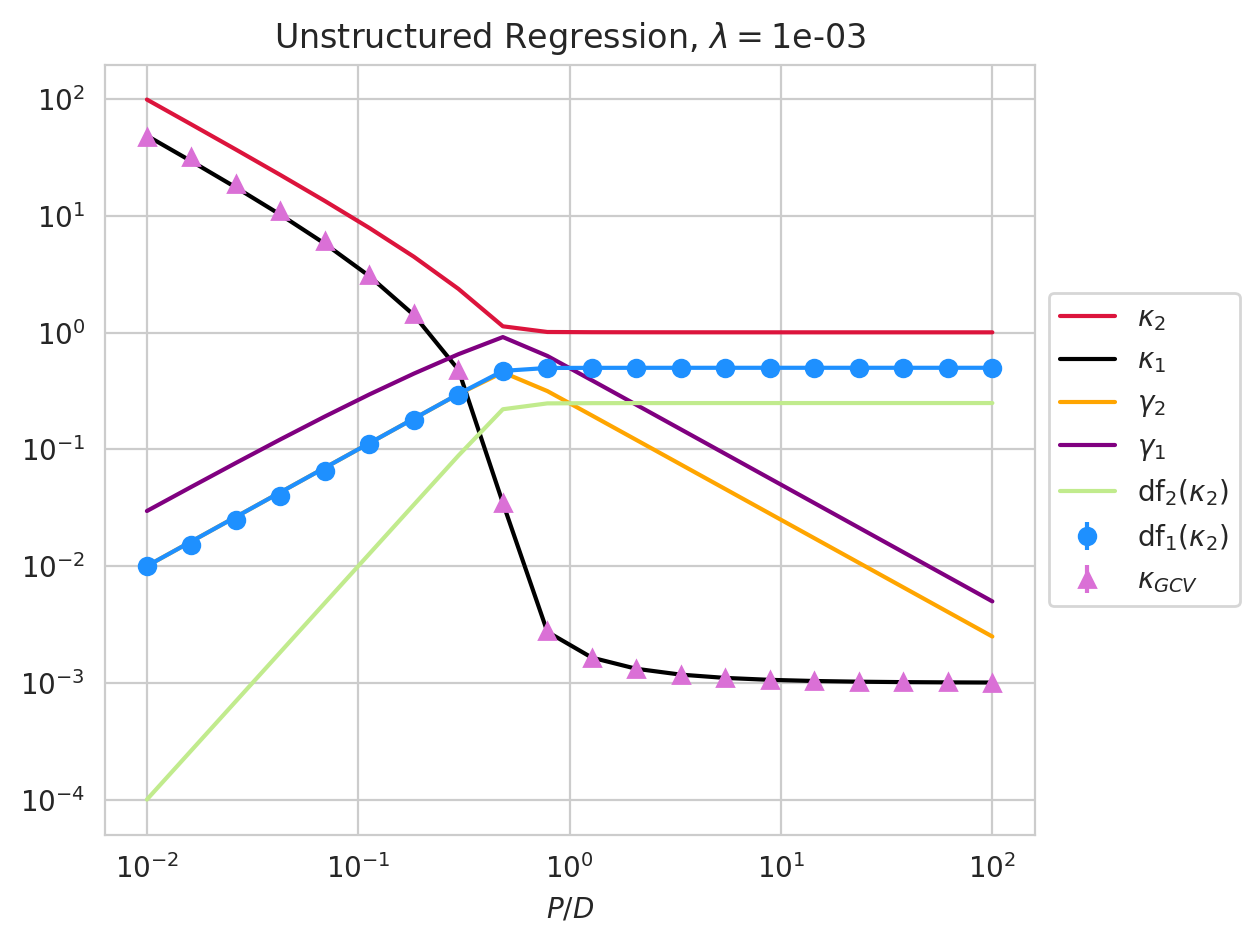

In [9]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(1/qs2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(1/qs2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(1/qs2, thry['gamma2'], label="$\\gamma_2$", c='orange')
plt.plot(1/qs2, thry['gamma1'], label="$\\gamma_1$", c='purple')
plt.plot(1/qs2, thry['df1k2'],  c='dodgerblue')
plt.errorbar(1/qs2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1(\\kappa_2)$", c='dodgerblue')
plt.plot(1/qs2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')
plt.errorbar(1/qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P/D$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
# plt.savefig('figures/LRF_unstructured_params.pdf', bbox_inches='tight')

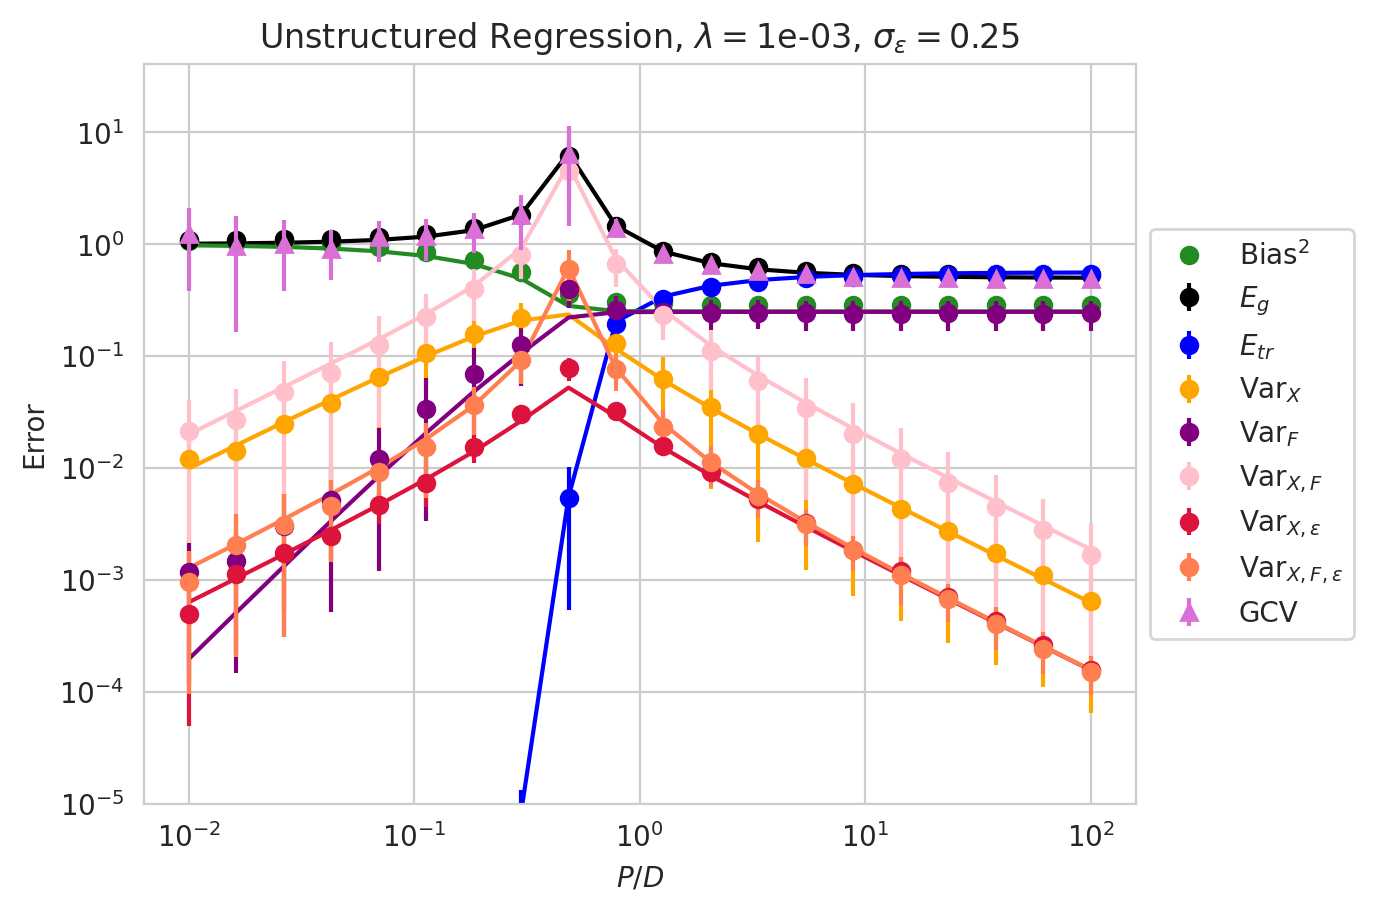

In [10]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'crimson', 'coral']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV_std/2, E_GCV_std)
plt.errorbar(1/qs, E_GCV,  E_GCV_std/1.2, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$P/D$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-5, top=None)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('figures/unstructured_LRF.pdf', bbox_inches='tight')

## Structured Shallow

### Variance Dominated

In [117]:
D = 10_000
N = 1000
qs = np.logspace(0, 4, 20)[1:]
qs2 =  np.logspace(0, 4, 20)
P_te = 200
ps = D/qs 
ps2 = D/qs2


num_F_seeds = 20
num_X_seeds = 20

alpha1 = 1.5
alpha2 = 0.0
r = 1.2
sigma_epsilon = 0.0
lamb=1e-5

etasX = jnp.arange(1, D+1)**(-alpha1)
etasF = jnp.arange(1, N+1)**(-alpha2)
SX = jnp.diag(etasX)
SF = jnp.diag(etasF)
w = jnp.arange(1, D+1)**(-(1 + alpha1 * (2*r - 1))/2)

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, etasX, [etasF], w, X_te, y_te, num_X_seeds, num_F_seeds)
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, etasX, None, w, anneal_steps=20)


100%|██████████| 19/19 [04:42<00:00, 14.89s/it]


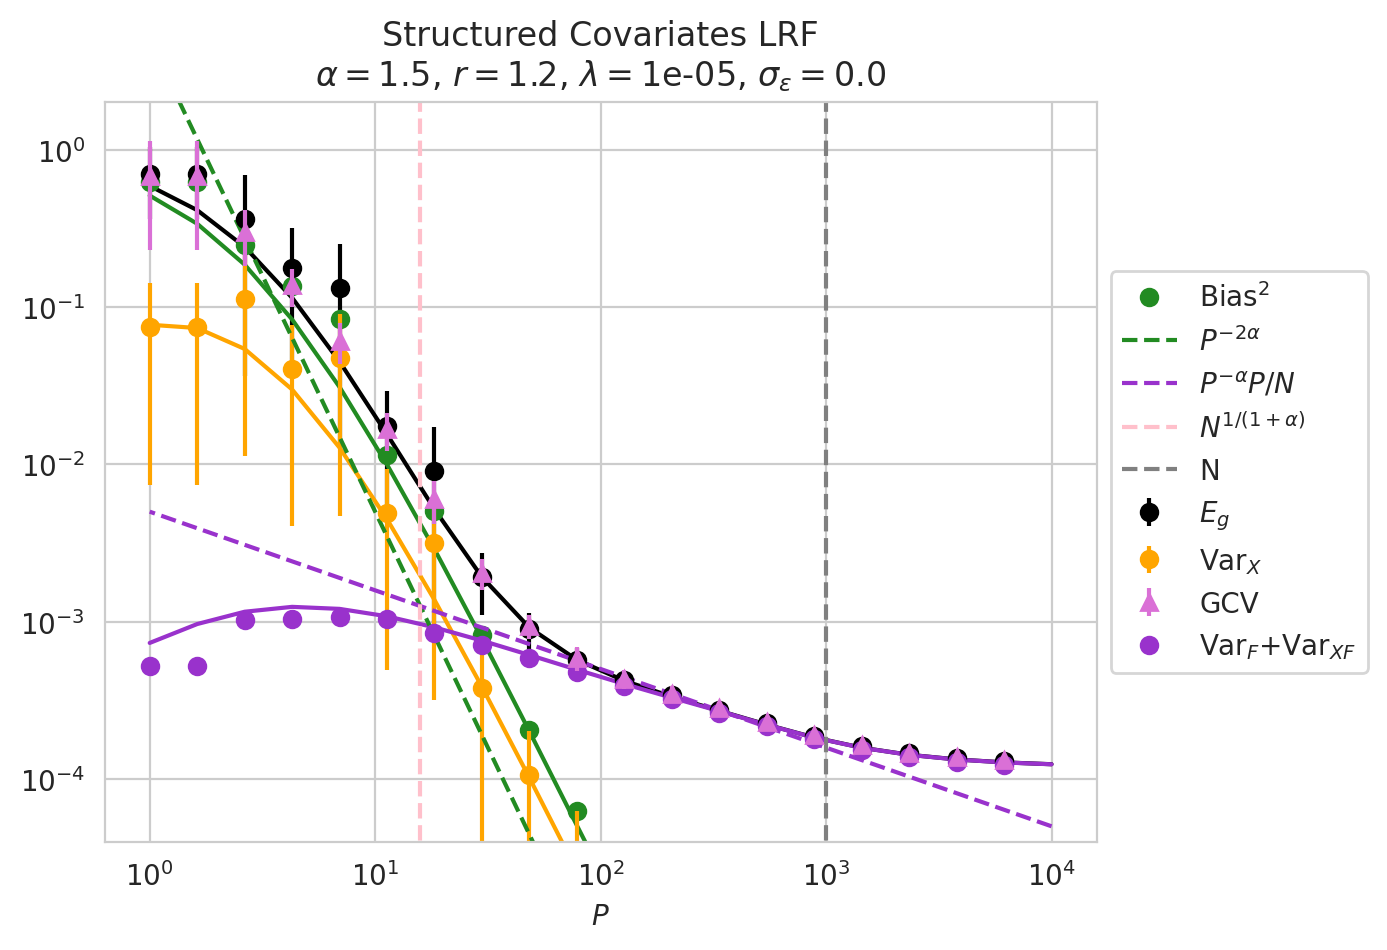

In [118]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$"]
for i in range(len(keys)):
    if i in [1, 4, 5]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV_std/2, E_GCV_std)
plt.errorbar(ps, E_GCV,  E_GCV_std/1.2, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)


plt.errorbar(ps, expt["VarF"] + expt["VarXF"], ls="", marker='o', c='darkorchid', label="Var$_F$+Var$_{{XF}}$")
plt.plot(ps2, thry['VarF']+thry['VarXF'], c='darkorchid')

label1 = "$P^{{-2\\alpha}}$" if r > 1 else "$P^{{-2\\alpha r}}$" 
label2 = "$P^{{-\\alpha}} P/N$" if r > 1/2 else "$P^{{-2\\alpha r}} \\frac{{P/N}}{{1-P/N}}$"
label3 = "$N^{{1/(1+\\alpha)}}$" if r > 1 else "$N^{{1/(1+\\alpha (2 r - 1))}}$"
plt.plot(ps2, 5*ps2**(-2*alpha1*min(r, 1)), '--', c='forestgreen', label=label1)
plt.plot(ps2, 5*ps2**(-2*alpha1*min(r, 1/2))*ps2/N, '--', c='darkorchid', label=label2)

Pf_exp = 1/(1+alpha1) if r > 1 else 1/(1+alpha1*(2*r-1))
plt.plot([N**Pf_exp, N**Pf_exp], [0, 1e1], linestyle='--', color='pink', label=label3)

plt.xscale('log')
plt.yscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N")
plt.ylim(bottom=4e-5, top=2e0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates LRF\n$\\alpha=${alpha1}, $r=${r}, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.savefig("figures/structured_LRF_OV.pdf", bbox_inches='tight')

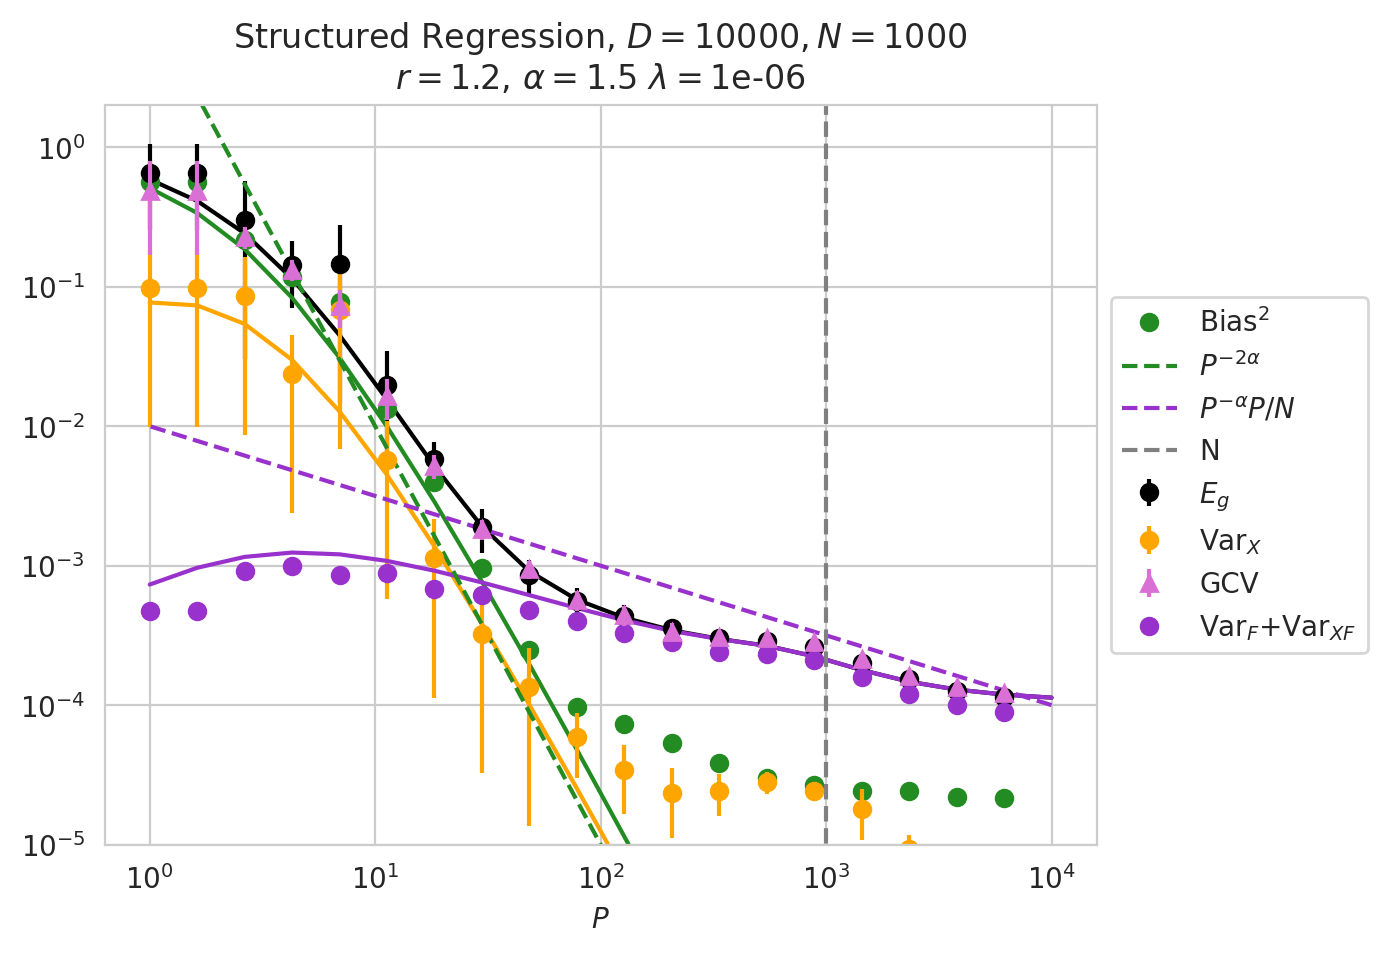

In [451]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$"]
for i in range(len(keys)):
    if i in [1, 4, 5]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV_std/2, E_GCV_std)
plt.errorbar(ps, E_GCV,  E_GCV_std/1.2, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)


plt.errorbar(ps, expt["VarF"] + expt["VarXF"], ls="", marker='o', c='darkorchid', label="Var$_F$+Var$_{{XF}}$")
plt.plot(ps2, thry['VarF']+thry['VarXF'], c='darkorchid')

label1 = "$P^{{-2\\alpha}}$" if r > 1 else "$P^{{-2\\alpha r}}$" 
label2 = "$P^{{-\\alpha}} P/N$" if r > 1/2 else "$P^{{-2\\alpha r}} \\frac{{P/N}}{{1-P/N}}$"
plt.plot(ps2, 1e1 * ps2**(-2*alpha1*min(r, 1)), '--', c='forestgreen', label=label1)
plt.plot(ps2, 1e1 * ps2**(-2*alpha1*min(r, 1/2)+1)/N + ps2**(-2*alpha1*min(r, 1/2)+2)/(N**2) , '--', c='darkorchid', label=label2)

Pf_exp = 1/(1+alpha1) if r > 1 else 1/(1+alpha1*(2*r-1))
plt.plot([N**Pf_exp, N**Pf_exp], [0, 1e1], linestyle='--', color='pink', label=label3)

plt.xscale('log')
plt.yscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N")
plt.ylim(bottom=1e-5, top=2e0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P$')
plt.title(f"Structured Regression, $D={D}, N={N}$\n$r=${r}, $\\alpha=${alpha1} $\\lambda=${lamb:.0e}")
plt.savefig("figures/structured_LRF_OV.pdf", bbox_inches='tight')

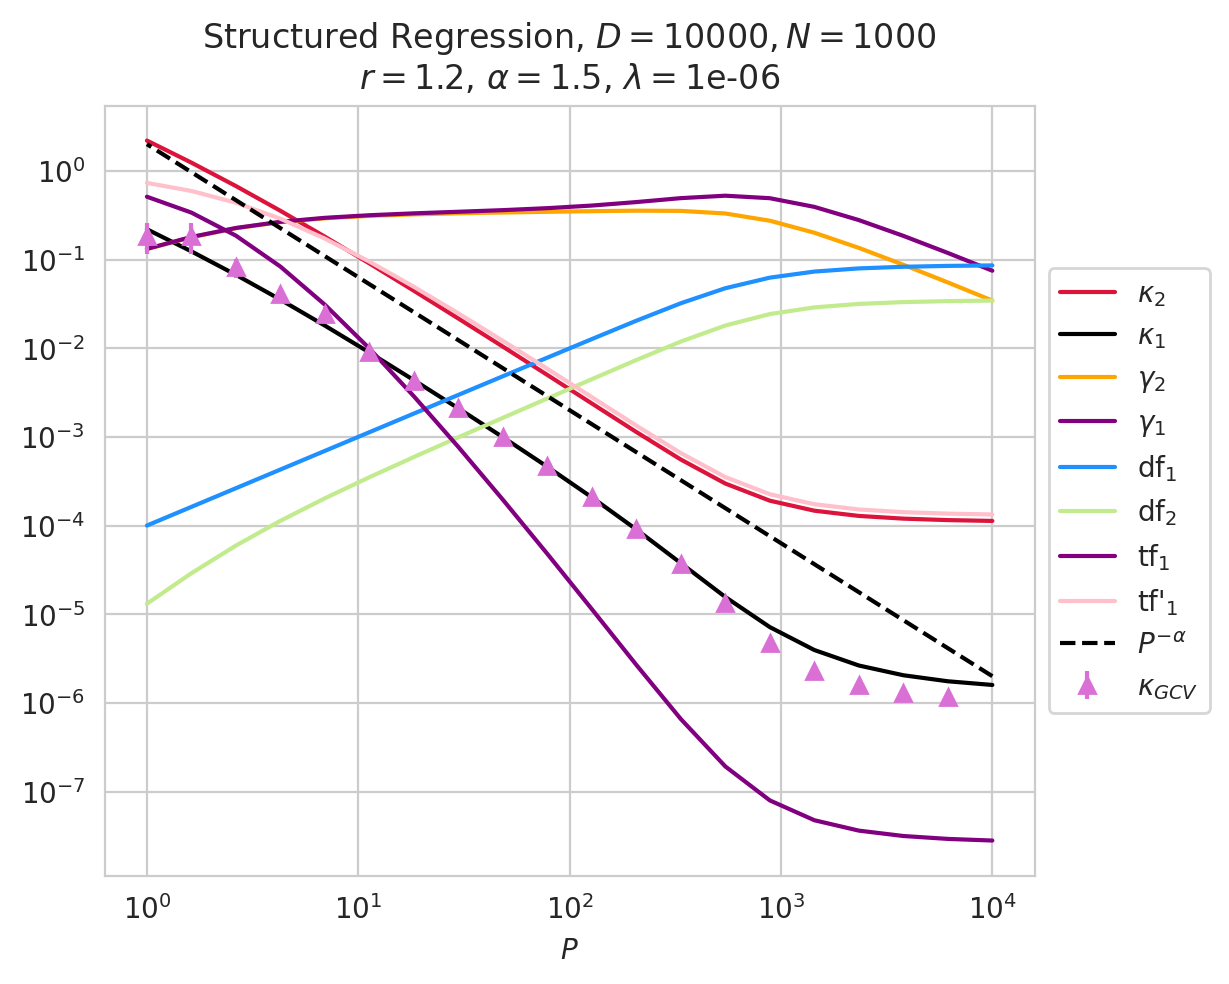

In [449]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(ps2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(ps2, thry['gamma2'], label="$\\gamma_2$", c='orange')
plt.plot(ps2, thry['gamma1'], label="$\\gamma_1$", c='purple')
plt.plot(ps2, thry['df1k2'], label="df$_1$", c='dodgerblue')
plt.plot(ps2, thry['df2k2'], label="df$_2$", c='C4')
plt.errorbar(ps, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.plot(ps2,  (thry['kappa2']**2)*thry['tf1pk2'], label="tf$_1$", c='purple')
plt.plot(ps2, thry['kappa2']*thry['tf1k2'], label="tf$'_1$", c='pink')

plt.plot(ps2, 2* ps2**(-alpha1), '--', c='k', label="$P^{-\\alpha}$")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P$')
plt.title(f"Structured Regression, $D={D}, N={N}$\n$r=${r}, $\\alpha=${alpha1}, $\\lambda=${lamb:.0e}")
plt.savefig("figures/structured_LRF_OV_params.pdf", bbox_inches='tight')

### Variance + Ridge Dominated

In [ ]:
qs = np.logspace(0.5, 4, 12)
qs2 =  np.logspace(0, 4, 20)
ps = D/qs 
ps2 = D/qs2

P_te = 200

lamb=1e-8

D = 10_000
N = 2000
num_F_seeds = 20
num_X_seeds = 20

alpha1 = 2.0
alpha2 = 0.0
r = 1.5
sigma_epsilon = 0.0
l = 1.5

etasX = jnp.arange(1, D+1)**(-alpha1)
etasF = jnp.arange(1, N+1)**(-alpha2)
SX = jnp.diag(etasX)
SF = jnp.diag(etasF)
w = jnp.arange(1, D+1)**(-(1 + alpha1 * (2*r - 1))/2)

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

lambs=1e0*(ps**(-l))
lambs2=1e0*(ps2**(-l))
expt = simulate_theory([D, N], qs, lambs, sigma_epsilon, etasX, [etasF], w, X_te, y_te, num_X_seeds, num_F_seeds)


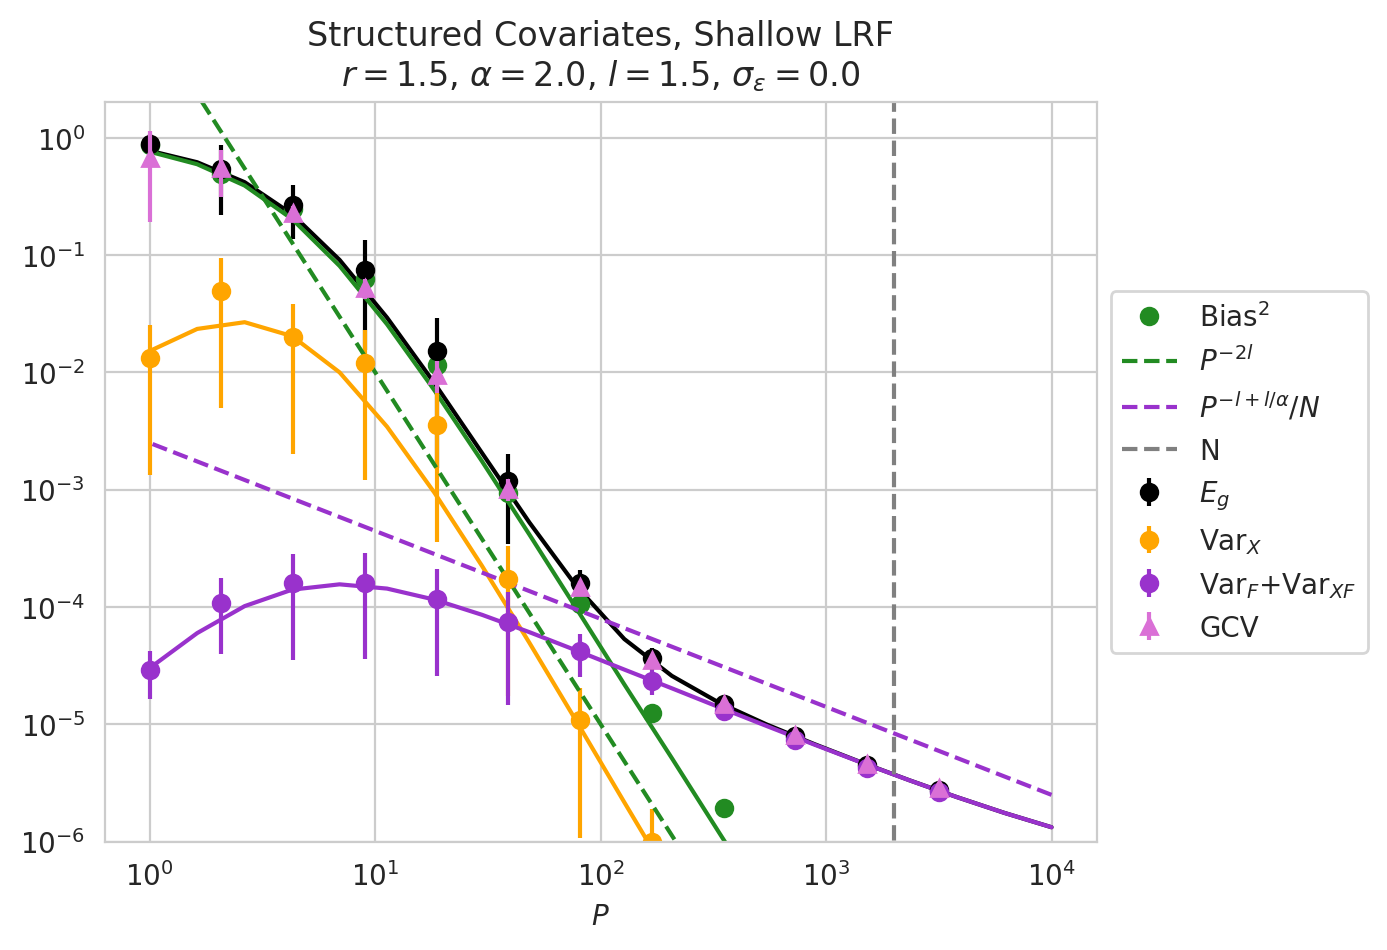

In [46]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'red', 'coral']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    if i in [1, 4, 5, 6, 7]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)
plt.errorbar(ps, expt["VarF"] + expt["VarXF"], np.minimum(expt["VarF_std"], expt["VarF"]*0.9), ls="", marker='o', c='darkorchid', label="Var$_F$+Var$_{{XF}}$")
plt.plot(ps2, thry['VarF']+thry['VarXF'], c='darkorchid')

E_GCV = (expt['kappa_GCV']/lambs)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lambs)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV_std/2, E_GCV_std)
plt.errorbar(ps, E_GCV,  E_GCV_std/1.2, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)


signal_exp = 2*min(l, alpha1)*min(r, 1)
var_exp = 2*min(l, alpha1)*min(r, 1/2)
noise_exp = max(0, (alpha1-l)/alpha1)
var_mit_exp = l - l/alpha1
if l > alpha1:        
    label1 = "$P^{{-2\\alpha}}$" if r > 1 else "$P^{{-2\\alpha r}}$" 
    label2 = "$P^{{-\\alpha+1}}/N$" if r > 1/2 else "$P^{{-2\\alpha r+1}}/N$"
else:
    label1 = "$P^{{-2l}}$" if r > 1 else "$P^{{-2l r}}$" 
    label2 = "$P^{{-l+1}}/N$" if r > 1/2 else "$P^{{-2 l r+1}}/N$"
label3 = "$P^{{-(\\alpha - l)/\\alpha}}$" 
label4 = "$P^{{-l + l/\\alpha}}/N$"
plt.plot(ps2, 1e1 * ps2**(-signal_exp), '--', c='forestgreen', label=label1)
# plt.plot(ps2, 5e0 *(ps2**(-var_exp)*ps2/N ) , '--', c='darkorchid', label=label2)
plt.plot(ps2, 5e0*(ps2**(-var_mit_exp) / N) , '--', c='darkorchid', label=label4)
# Pf_exp = 1/(1+min(l, alpha1)) if r > 1 else 1/(1+min(l,alpha1)*(2*r-1))
# if Pf_exp < 1:
#     if l < alpha1:
#         label3 = "$N^{{1/(1+l)}}$" if r > 1 else "$N^{{1/(1+l (2 r - 1))}}$"
#     else:
#         label3 = "$N^{{1/(1+\\alpha)}}$" if r > 1 else "$N^{{1/(1+\\alpha (2 r - 1))}}$"
#     plt.plot([N**Pf_exp, N**Pf_exp], [0, 1e1], linestyle='--', color='pink', label=label3)

plt.xscale('log')
plt.yscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N")
plt.ylim(bottom=1e-6, top=2e0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates, Shallow LRF\n$r=${r}, $\\alpha=${alpha1}, $l=${l}, $\\sigma_\\epsilon=${sigma_epsilon}")

plt.savefig("figures/structured_LRF_Variance_Ridge_Dominated.pdf", bbox_inches='tight')

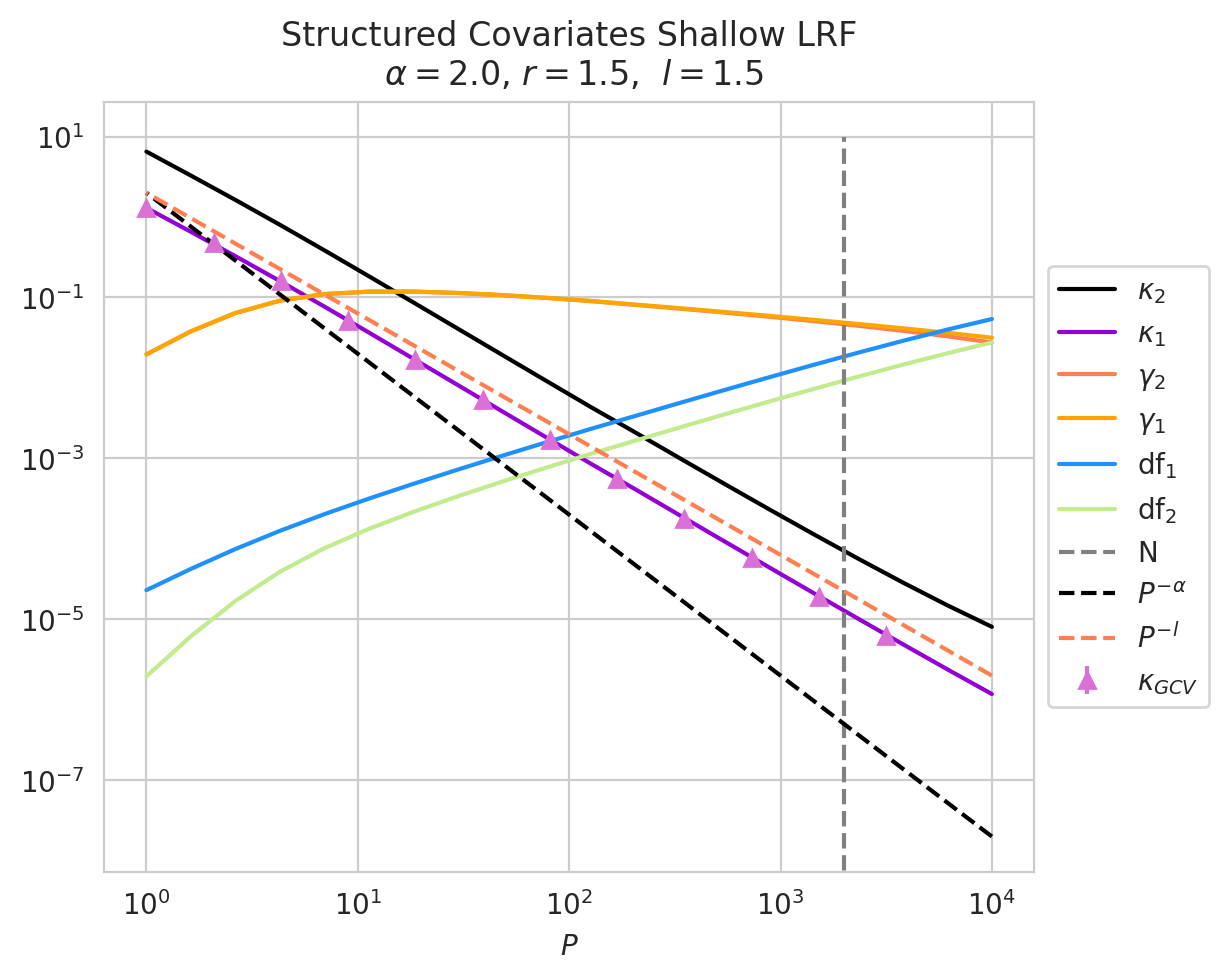

In [330]:
sns.set_palette('rainbow', n_colors=7)

ps = D/qs
ps2 = D/qs2

plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa2'], label="$\\kappa_2$", c='k')
plt.plot(ps2, thry['kappa1'], label="$\\kappa_1$", c='darkviolet')
plt.plot(ps2, thry['gamma2'], label="$\\gamma_2$", c='coral')
plt.plot(ps2, thry['gamma1'], label="$\\gamma_1$", c='orange')
plt.plot(ps2, thry['df1k2'], label="df$_1$", c='dodgerblue')
plt.plot(ps2, thry['df2k2'], label="df$_2$", c='C4')
plt.errorbar(ps, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.plot([N, N], [0, 1e1], linestyle='--', color='grey', label="N")
plt.plot(ps2, 2* ps2**(-alpha1), '--', c='k', label="$P^{-\\alpha}$")
plt.plot(ps2, 2* ps2**(-l), '--', c='coral', label="$P^{{-l}}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates Shallow LRF\n $\\alpha=${alpha1}, $r=${r},  $l=${l}")
plt.savefig("figures/structured_LRF_Variance_Ridge_Dominated_params.pdf", bbox_inches='tight')

### Noise Mitigated

In [ ]:
qs = np.logspace(0, 4, 12)[1:]
qs2 =  np.logspace(0, 4, 20)
ps = D/qs 
ps2 = D/qs2

D = 10_000
N = 2000
P_te = 200
num_F_seeds = 40
num_X_seeds = 40

alpha1 = 3.0
alpha2 = 0.0
r = 0.3
sigma_epsilon = 0.4
l = 2.0

etasX = jnp.arange(1, D+1)**(-alpha1)
etasF = jnp.arange(1, N+1)**(-alpha2)
SX = jnp.diag(etasX)
SF = jnp.diag(etasF)
w = jnp.arange(1, D+1)**(-(1 + alpha1 * (2*r - 1))/2)

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

lambs=1e0*(ps**(-l))
lambs2=1e0*(ps2**(-l))
expt = simulate_theory([D, N], qs, lambs, sigma_epsilon, etasX, [etasF], w, X_te, y_te, num_X_seeds, num_F_seeds)
thry = solve_theory([D, N], qs2, lambs2, sigma_epsilon, etasX, None, w, anneal_steps=10)

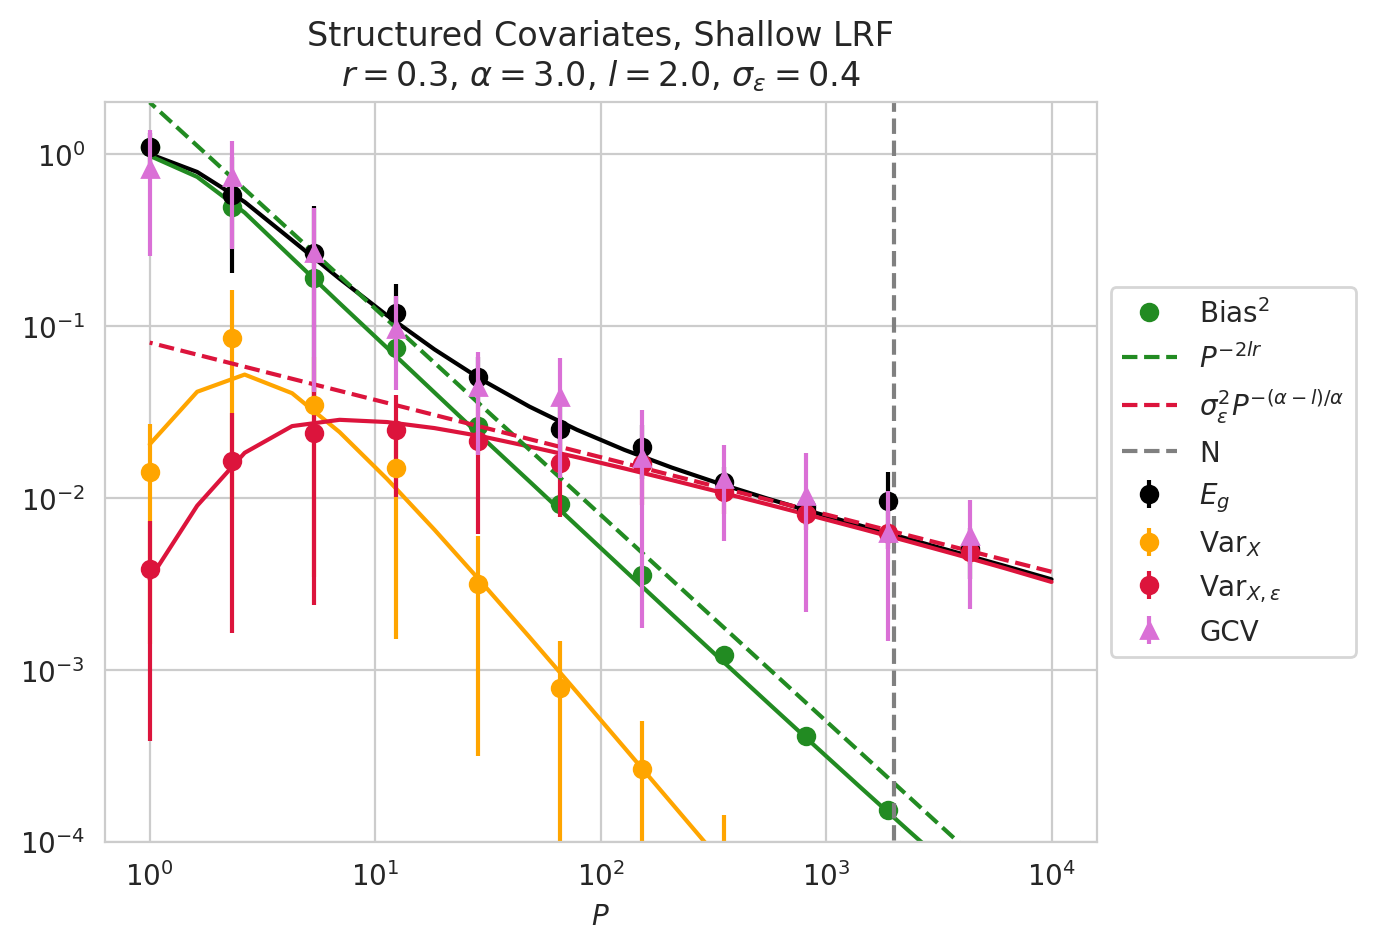

In [40]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'crimson', 'coral']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    if i in [1, 4, 5, 7]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)
E_GCV = (expt['kappa_GCV']/lambs)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lambs)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV_std*0.6, E_GCV_std)
plt.errorbar(ps, E_GCV,  E_GCV_std*0.9, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

signal_exp = 2*min(l, alpha1)*min(r, 1/2)
var_exp = 2*min(l, alpha1)*min(r, 1/2)
noise_exp = max(0, (alpha1-l)/alpha1)
if l > alpha1:        
    label1 = "$P^{{-2\\alpha}}$" if r > 1 else "$P^{{-2\\alpha r}}$" 
    label2 = "$P^{{-\\alpha+1}}/N$" if r > 1/2 else "$P^{{-2\\alpha r+1}}/N$"
else:
    label1 = "$P^{{-2\\l}}$" if r > 1 else "$P^{{-2l r}}$" 
    label2 = "$P^{{-l+1}}/N$" if r > 1/2 else "$P^{{-2 l r+1}}/N$"
label3 = "$\\sigma_{{\\epsilon}}^2 P^{{-(\\alpha - l)/\\alpha}}$" 

plt.plot(ps2, 2e0 * ps2**(-signal_exp), '--', c='forestgreen', label=label1)
plt.plot(ps2, 5e-1* sigma_epsilon**2 *(ps2**(-noise_exp) ) , '--', c='crimson', label=label3)
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N")
plt.ylim(bottom=1e-4, top=2e0)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates, Shallow LRF\n$r=${r}, $\\alpha=${alpha1}, $l=${l}, $\\sigma_\\epsilon=${sigma_epsilon}")

plt.savefig("figures/structured_LRF_Noise_Mitigated.pdf", bbox_inches='tight')

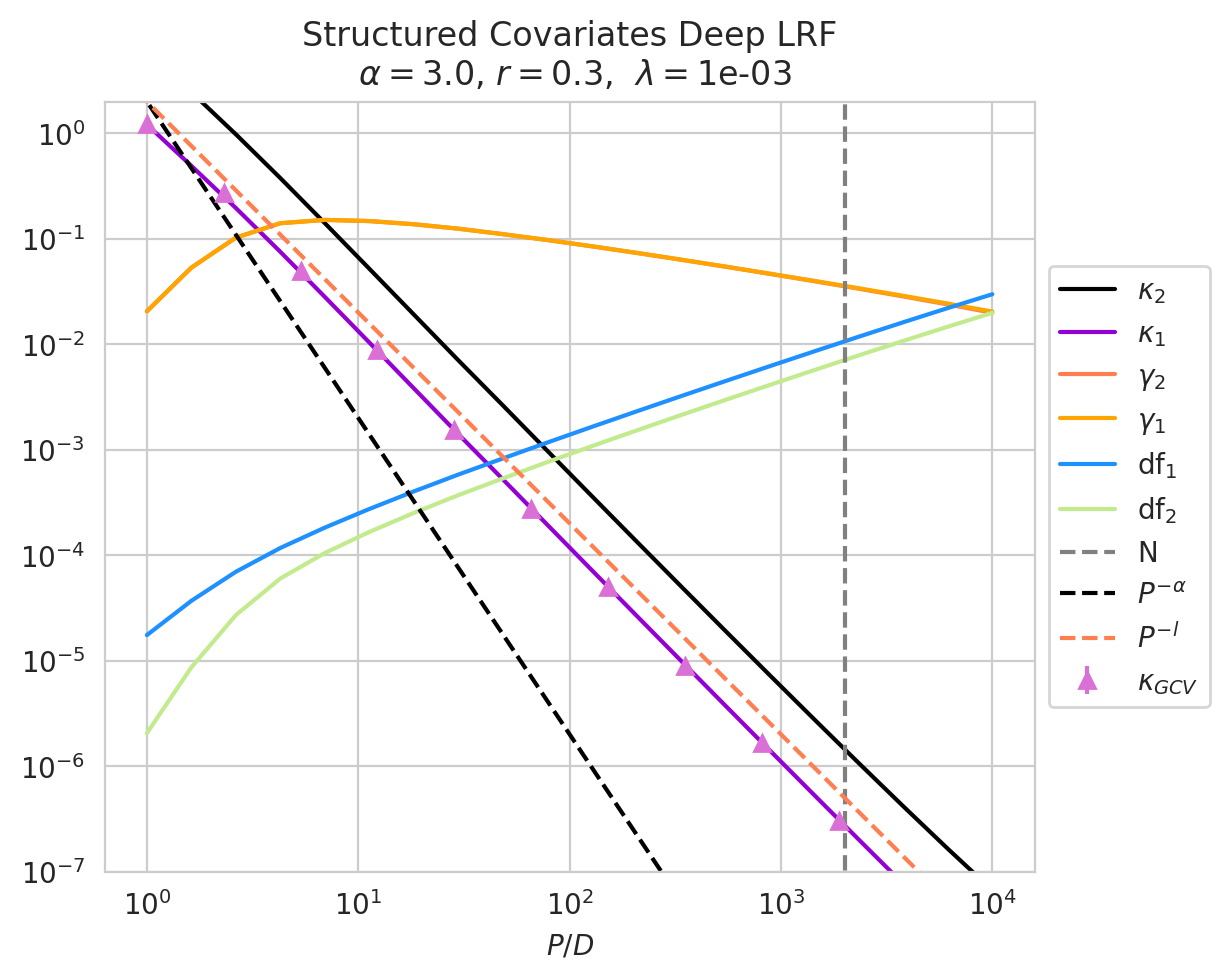

In [32]:
sns.set_palette('rainbow', n_colors=7)

ps = D/qs
ps2 = D/qs2

plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa2'], label="$\\kappa_2$", c='k')
plt.plot(ps2, thry['kappa1'], label="$\\kappa_1$", c='darkviolet')
plt.plot(ps2, thry['gamma2'], label="$\\gamma_2$", c='coral')
plt.plot(ps2, thry['gamma1'], label="$\\gamma_1$", c='orange')
plt.plot(ps2, thry['df1k2'], label="df$_1$", c='dodgerblue')
plt.plot(ps2, thry['df2k2'], label="df$_2$", c='C4')
plt.errorbar(ps, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.plot([N, N], [0, 1e1], linestyle='--', color='grey', label="N")
plt.plot(ps2, 2* ps2**(-alpha1), '--', c='k', label="$P^{-\\alpha}$")
plt.plot(ps2, 2* ps2**(-l), '--', c='coral', label="$P^{{-l}}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-7, top=2e0)
plt.xlabel(r'$P/D$')
plt.title(f"Structured Covariates Deep LRF\n $\\alpha=${alpha1}, $r=${r},  $\\lambda=${lamb:.0e}")
plt.savefig("figures/structured_LRF_Noise_Mitigated_params.pdf", bbox_inches='tight')

## Deep LRF 

In [95]:
qs = np.logspace(0, 3, 20)
qs2 = qs
P_te = 200
sigma_epsilon = 0.

Ns = [2000, 1000, 1000]
D = Ns[0]
N = min(Ns[1:])
L = len(Ns)

num_F_seeds = 20
num_X_seeds = 20

lamb = 1e-5
alpha1 = 1.5
r = 0.7

alphas = [alpha1, 0.0, 0.0]
all_etas= [jnp.arange(1, N+1)**(-alpha) for alpha, N in zip(alphas, Ns)]
Ss = [jnp.diag(etas) for etas in all_etas]
SX = Ss[0]
w = jnp.arange(1, D+1)**(-(1 + alpha1 * (2*r - 1))/2)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

expt = simulate_theory(Ns, qs, lamb, sigma_epsilon, all_etas[0], all_etas[1:], w, X_te, y_te, num_X_seeds, num_F_seeds)
thry = solve_theory(Ns, qs2, lamb, sigma_epsilon, all_etas[0], None, w, anneal_steps=24)


100%|██████████| 20/20 [01:25<00:00,  4.29s/it]


Text(0.5, 1.0, 'Structured Covariates Deep LRF\n $\\alpha=$1.5, $r=$0.7,  $\\lambda=$1e-05')

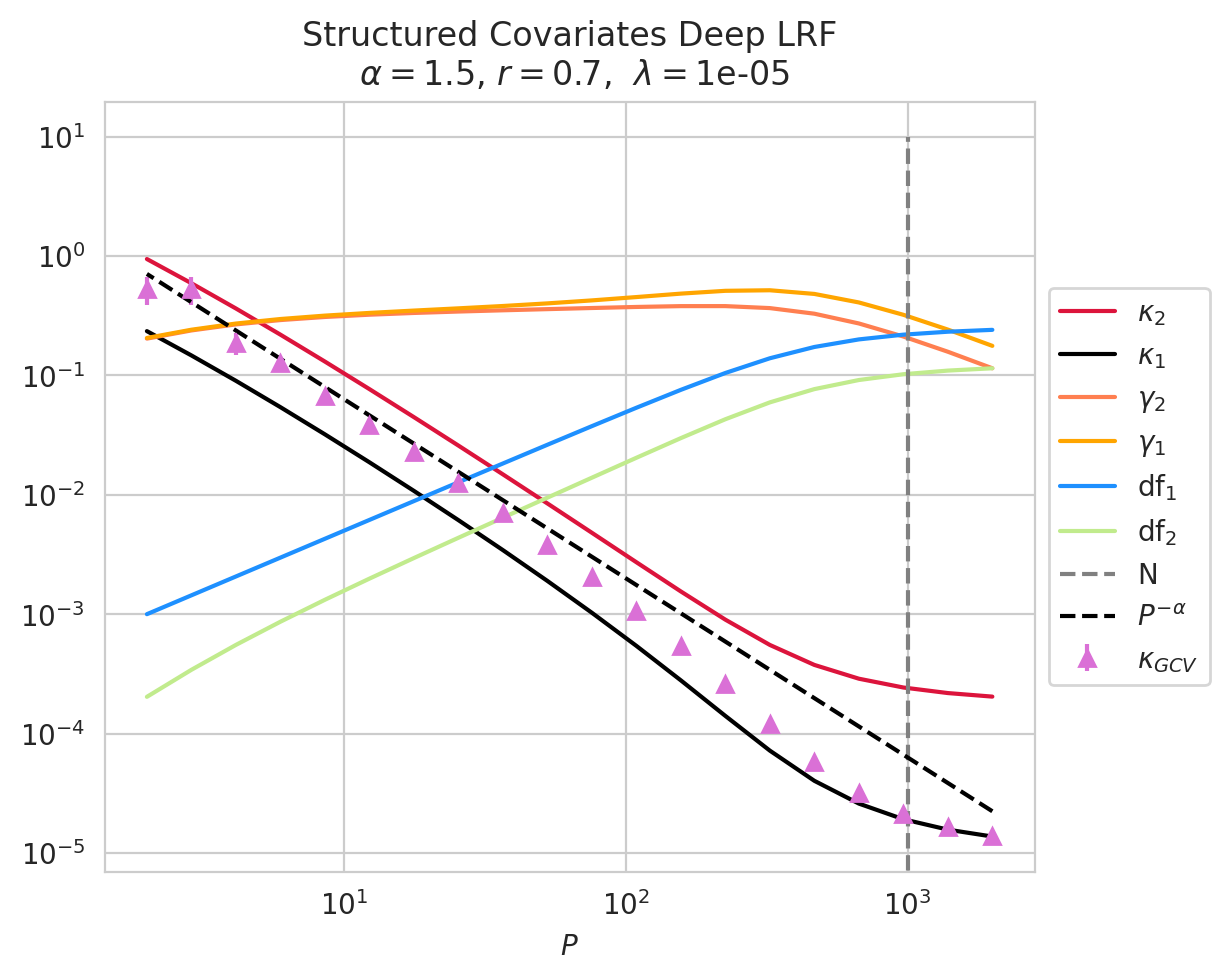

In [106]:
sns.set_palette('rainbow', n_colors=7)

ps = D/qs
ps2 = D/qs2

plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(ps2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(ps2, thry['gamma2'], label="$\\gamma_2$", c='coral')
plt.plot(ps2, thry['gamma1'], label="$\\gamma_1$", c='orange')
plt.plot(ps2, thry['df1k2'], label="df$_1$", c='dodgerblue')
# plt.plot(ps2, thry['kappa2']*(N/D - thry['df1k2'])**2, 'o', label="df$_1$ emp", c='dodgerblue')
plt.plot(ps2, thry['df2k2'], label="df$_2$", c='C4')
plt.errorbar(ps2, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.plot([N, N], [0, 1e1], linestyle='--', color='grey', label="N")
plt.plot(ps2, 2* ps2**(-alpha1), '--', c='k', label="$P^{-\\alpha}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates Deep LRF\n $\\alpha=${alpha1}, $r=${r},  $\\lambda=${lamb:.0e}")
# plt.savefig('figures/deep_structured_LRF_OV_params.pdf', bbox_inches='tight')

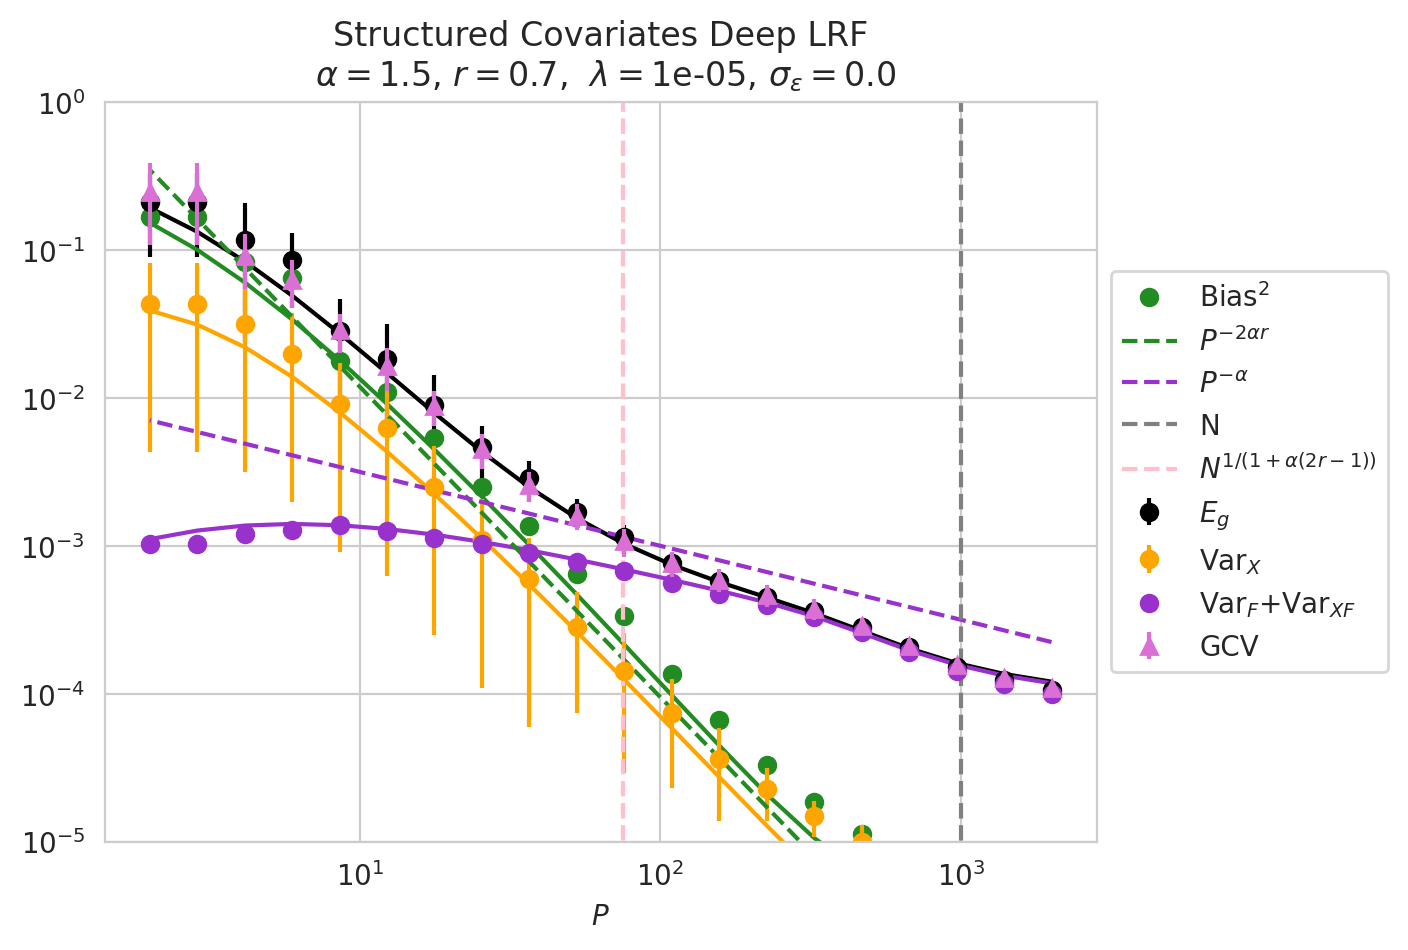

In [97]:
N = min(Ns[1:])
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$"]
for i in range(len(keys)):
    if i in [1, 4, 5]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)

plt.errorbar(ps, expt["VarF"] + expt["VarXF"], ls="", marker='o', c='darkorchid', label="Var$_F$+Var$_{{XF}}$")
plt.plot(ps, thry['VarF']+thry['VarXF'], c='darkorchid')

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV/2, E_GCV_std)
plt.errorbar(ps, E_GCV,  E_GCV_std, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

label1 = "$P^{{-2\\alpha}}$" if r > 1 else "$P^{{-2\\alpha r}}$" 
label2 = "$P^{{-\\alpha}}$" if r > 1/2 else "$P^{{-2\\alpha r}}$"
label3 = "$N^{{1/(1+\\alpha)}}$" if r > 1 else "$N^{{1/(1+\\alpha (2 r - 1))}}$"
plt.plot(ps2, 1.5*ps2**(-2*alpha1*min(r, 1)), '--', c='forestgreen', label=label1)
plt.plot(ps2, 1e1*(ps2**(-2*alpha1*min(r, 1/2)+1)/N ) , '--', c='darkorchid', label=label2)

plt.plot([N, N], [0, 1e1], linestyle='--', color='grey', label="N")
Pf_exp = 1/(1+alpha1) if r > 1 else 1/(1+alpha1*(2*r-1))
plt.plot([N**Pf_exp, N**Pf_exp], [0, 1e1], linestyle='--', color='pink', label=label3)

plt.xlabel(r'$P$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1e0)
plt.title(f"Structured Covariates Deep LRF\n $\\alpha=${alpha1}, $r=${r},  $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/deep_structured_LRF_OV.pdf', bbox_inches='tight')